# Tutorial 2: Uncertainty Experiments with the PyEOSim Framework
#### Joe Fennell | September 2024

The purpose of this notebook is to provide access to additional datasets and provide an example of running an experiment with the system emulator.

In the first part, we will set up the model as with the previous experiment.

## Toy Scenario: Defining System Requirements for a New Sensor
You have been tasked with identifying the effect of system read noise on the final performance of a scene classification algorithm.

We have a tool with the ability to simulate different read noises (whilst keeping other parameters constant).

What would you do? 

*My notes here:* 

In [1]:
# you'll need to install these if you haven't already...
# !pip install rioxarray
# !pip install geopandas
# !pip install scikit-learn

import geopandas
import rioxarray
import sklearn

from pyeosim import atmosphere, spectral
from pyeosim import post
from pyeosim import imager

import Py6S
import pyproj

from datetime import datetime
import xarray
import matplotlib.pyplot as plt

As in the previous example, we will set up a mock Sentinel 2 system using hyperspectral reflectance data as the input. Our system will output simulated Digital Number values (as in Tutorial 1):

In [2]:
# stored as uint16 but needs to be converted to fractional [0-1] reflectance for the atmospheric transformer
mk_vnir_reflectance = xarray.open_dataset('data/Milton_Keynes_aerial_VisVNIR.nc')['reflectance'] / 10000

# the dimension coordinate must be wavelength
mk_vnir_reflectance = mk_vnir_reflectance.swap_dims({'band': 'wavelength'})

# transform the coordinates from UTM to Lat/Lon
crs_transformer = pyproj.Transformer.from_crs('epsg:32630', 'epsg:4326')
position = (652145, 5763546) # top left corner of array

for pt in crs_transformer.itransform([position]):
    lat, lon = pt

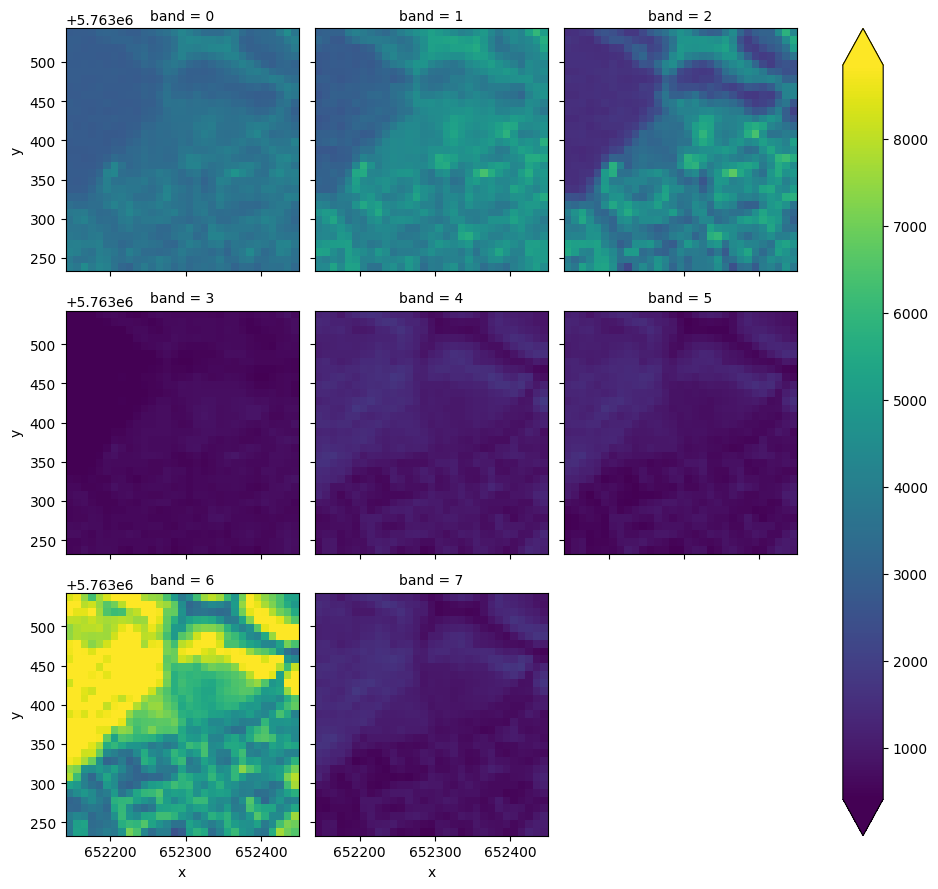

In [3]:
# standard Sentinel 2 VNIR bands:

Sentinel2A_SRF = spectral.Sentinel2VNIR()

def generate_atmosphere(lat, lon, hour, day, month, view_a=0, view_z=0, SRF=None):
    
    OZONE = 0.00735 # central UK average from MODIS for March-September 2021
    AOT = 0.16 # typical UK summer Aerosol Optical Thickness
    # AOT = 1 # typical UK summer Aerosol Optical Thickness
    WVP = 1.37 # typical UK summer Water Vapour
    s = Py6S.SixS()
    
    s.altitudes.set_sensor_satellite_level()
    
    s.ground_reflectance = Py6S.GroundReflectance.HomogeneousLambertian(1)
    s.atmos_profile = Py6S.AtmosProfile().UserWaterAndOzone(WVP, OZONE)
    s.aot550 = AOT
    
    # setup the geometries
    s.geometry = Py6S.Geometry.User()
    s.geometry.from_time_and_location(
        lat,
        lon,
        datetime(2020, month, day, hour, 0).isoformat(),
        view_z,
        view_a)
    
    t = atmosphere.SixSV_atmosphere(s, SRF)
    return t

# Same atmosphere as previous:
atmosphere_1 = generate_atmosphere(
    lat=lat,
    lon=lon,
    hour=13,
    day=22,
    month=6
)

atmosphere_1.fit(Sentinel2A_SRF)


# use the atmosphere as a transformer
mk_vnir_toa = atmosphere_1.transform(mk_vnir_reflectance)

# Quantum Efficiencies per band
Sentinel2_Q_e = xarray.DataArray(
    [.67, .7, .71, .59, .5, .46, .3, .26],
    coords={'band': [0,1,2,3,4,5,6,7]}
)

# Conversion gain (microvolts/ electron) per band
Sentinel2_conversion_gain = xarray.DataArray(
    [3.5, 5.8, 6.1, 1.9, 2.1, 1.7, 4.4, 3.3],
    coords={'band': [0,1,2,3,4,5,6,7]}
)

# generate the 10m imager
imager10m = imager.TdiCmos(
    sensor_altitude=786000.0,
    sensor_ground_speed=75000,
    ground_sample_distance=10,
    lens_diameter=0.15,
    psf_fwhm=13, # estimate
    TDI_rows=10,
    pix_per_row=2596, 
    sensor_width=(2596*7.5)/1000, # estimate
    pixel_area=7.5**2,
    spectral_response=Sentinel2A_SRF,
    quantum_efficiency=Sentinel2_Q_e,
    full_well=100000, # estimate
    prnu_factor=0.01, # estimate
    dark_current=5, # estimate
    dark_factor=0.01, # estimate
    offset_factor=0.001, # estimate
    ccd_vref=3.1, # estimate
    sense_node_gain=Sentinel2_conversion_gain,
    read_noise=10, # we will be varying this
    adc_vref=1, # fixed to 1 but may be adjusted
    bit_depth=14,
    store_steps=False,
    apply_spatial_resampling=True)


# use the atmosphere as a transformer
mk_vnir_toa = atmosphere_1.transform(mk_vnir_reflectance)

# transform the TOA radiance to DN
mk_vnir_DN = imager10m.fit_transform(mk_vnir_toa)

# plot it out:
mk_vnir_DN.plot(col='band', col_wrap=3, robust=True)

## Correction to Radiance
In the previous notebook, we generated the raw system output in Digital Number. We need to correct back to bottom of atmosphere by first applying a Radiometric Correction to the Digital Number signal (converts DN to radiance $L$), and then inverting the atmospheric model (atmospheric correction) to generate Bottom-Of-Atmosphere Reflectance. In this case, we do a perfect inversion (i.e. the same 6SV atmosphere used to generate the atmosphere was also used to correct it)

In [4]:
correction_coefs = post.sensor_correction_experiment(
    toa_radiance=mk_vnir_toa,
    sensor=imager10m
)

S2A_TOA_radiance_correction = post.LinearRadiometricCorrection(correction_coefs)

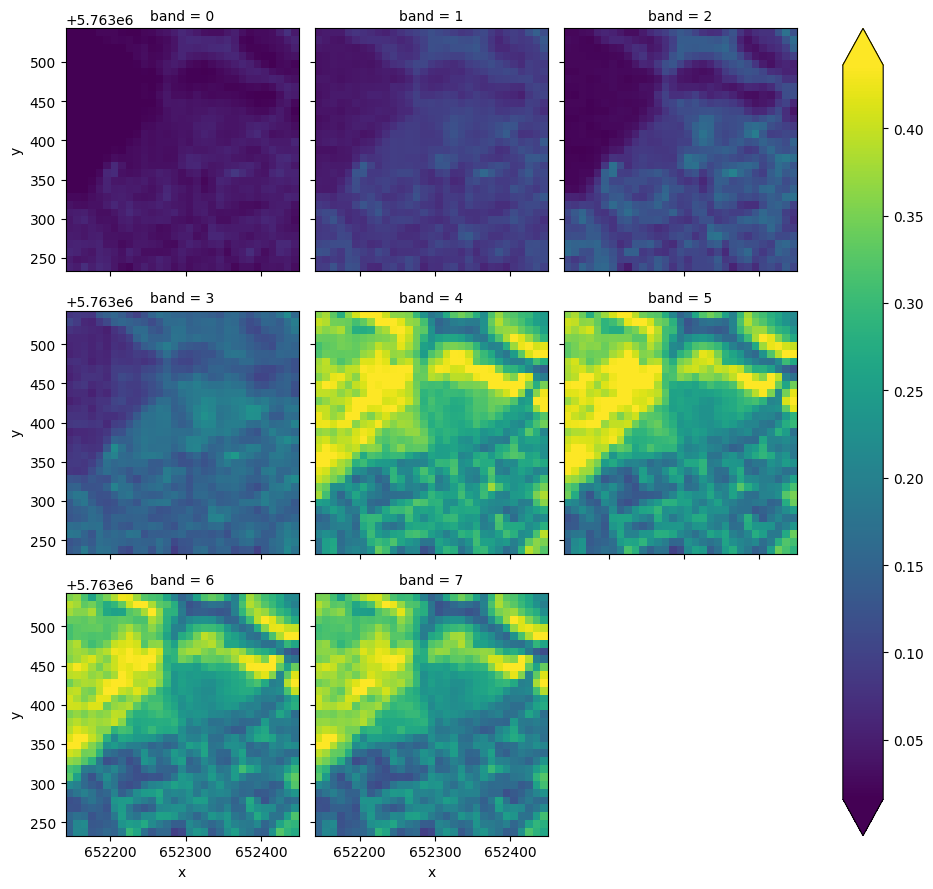

In [5]:
mk_vnir_boa_perfect_ac = atmosphere_1.inverse_transform(S2A_TOA_radiance_correction.transform(mk_vnir_DN))

mk_vnir_boa_perfect_ac.plot(col='band', robust=True, col_wrap=3)

## Scene Classification Algorithm
We are going to run a very simple, 2-class scene classifier, using Scikit-Learn. The two classes are 'vegetation' and 'other'. For our test scene, we have a corresponding label array (in vector format) that has polygons covering all vegetation in the scene. Anything not covered by vegetation is considered other land cover. There are no missing data or bad pixels in the scene.

We will use the GPKG (GeoPackage) vector file to generate mask arrays for a binary classification:

In [6]:
gdf = geopandas.read_file(
    'data/Milton_Keynes_labels.gpkg'
)

# look at the top 5 rows
gdf.head()

,Class,geometry
0,Mixed,"MULTIPOLYGON (((652168.64 5763546.33, 652183.4..."
1,Mixed,"MULTIPOLYGON (((652225.938 5763510.142, 652245..."
2,Grass,"MULTIPOLYGON (((652235.76 5763546.33, 652257.0..."
3,Grass,"MULTIPOLYGON (((652265.055 5763507.471, 652266..."
4,Grass,"MULTIPOLYGON (((652284.183 5763503.421, 652287..."


In [7]:
gdf['Class'].unique() # there are more classes available, we will just use tree and UH (unhealthy) tree as our overall tree label

array(['Mixed', 'Grass', 'Tree', 'Uh tree'], dtype=object)

<Axes: >

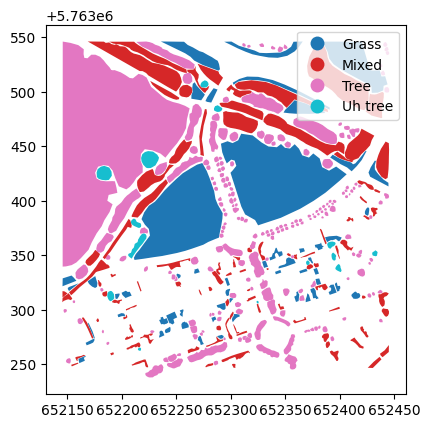

In [8]:
gdf.plot(column='Class', legend=True)

In [9]:
import numpy as np
def make_masks(image_array, gdf, class_1 = ['Tree', 'Uh tree', 'Grass', 'Mixed'], test_frac=.2):
    """Generates all masks needed to convert our image array into Scikit-Learn format
    
    Returns: label_mask, training_idxs, testing_idxs
    """
    all_tree_geoms = gdf[gdf['Class'].isin(class_1)].geometry
    mask = (image_array.rio.clip(all_tree_geoms, drop=False).isel(band=0) > 0).astype(int)
    mask = mask.interp_like(image_array.isel(band=0)).values

    # make a randomised split of training and testing
    idxs = np.arange(np.prod(mask.shape))
    cut = int(len(idxs) *test_frac)
    np.random.shuffle(idxs)
    return mask, idxs[cut:], idxs[:cut]

def image_to_sklearn(image_array, mask):
    """Reshapes to SKLearn format

    Returns: X, y
    """
    return image_array.stack({'pixel': ['y', 'x']}).values.T, mask.ravel()

In [10]:
# generate the masks and train test split - these stay fixed for the whole experiment
mask, train_idx, test_idx = make_masks(mk_vnir_boa_perfect_ac, gdf)
X, y = image_to_sklearn(mk_vnir_boa_perfect_ac, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09364462087252773..1.820485349338128].


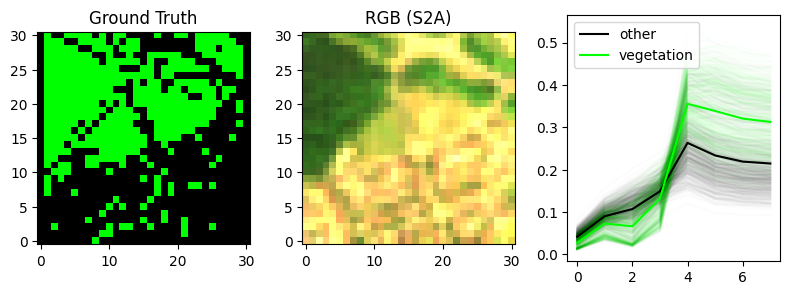

In [11]:
from matplotlib.colors import ListedColormap
f, a = plt.subplots(1,3, figsize=(8,3))

a[0].imshow(mask, origin='lower', cmap=ListedColormap(['k', 'lime']))
a[0].set_title('Ground Truth')

a[1].imshow(mk_vnir_boa_perfect_ac.isel(band=[2,1,0]).values.transpose([1,2,0]) * 9, origin='lower')
a[1].set_title('RGB (S2A)')

a[2].plot(X[y==0].T, alpha=.01, c='k')
a[2].plot(X[y==1].T, alpha=.01, c='lime')

a[2].plot(X[y==0].T.mean(1), alpha=1, c='k', label='other' )
a[2].plot(X[y==1].T.mean(1), alpha=1, c='lime', label='vegetation' )

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [13]:
N_REPS = 10
READ_NOISE = np.array([0, 10, 100, 1000, 3000]) # <- what we are varying
F1_SCORE = [] # <- what we want to know, as a function of READ_NOISE

for rn in READ_NOISE:
    _f1_scores = []
    # generate a new imager
    imager10m.read_noise = rn
    
    _ar = imager10m.fit_transform(mk_vnir_toa)

    # only do the correction experiment once for each noise level
    correction_coefs = post.sensor_correction_experiment(
        toa_radiance=mk_vnir_toa,
        sensor=imager10m
    )

    # Generate the radimetric correction module
    S2A_TOA_radiance_correction = post.LinearRadiometricCorrection(correction_coefs)

    for i in range(N_REPS):
        # transform the radiance data to DN
        _ar = imager10m.fit_transform(mk_vnir_toa)
        
        # correct DNs back to radiance and then reflectance
        _ar = atmosphere_1.inverse_transform(S2A_TOA_radiance_correction.transform(_ar))
        
        # reshape arrays for SKLearn
        X, y = image_to_sklearn(_ar, mask)

        # fit a new regression model on the training data
        regression_model = LogisticRegression()
        regression_model.fit(X[train_idx], y[train_idx])

        # generate predictions on the test data
        _yp = regression_model.predict(X[test_idx])

        # calculate the F1 score
        _f1_scores.append(float(f1_score(y[test_idx], _yp)))
    F1_SCORE.append(_f1_scores)
    print('completed RN={}'.format(rn))
        

completed RN=0
completed RN=10
completed RN=100
completed RN=1000
completed RN=3000


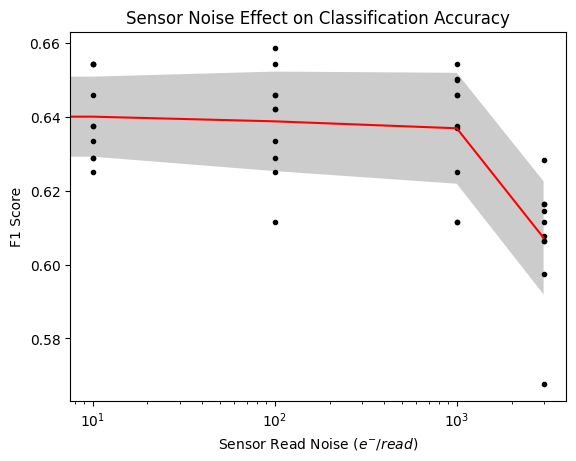

In [14]:
plt.plot(READ_NOISE, np.array(F1_SCORE), marker='.', ls='None', c='k')
plt.plot(READ_NOISE, np.array(F1_SCORE).mean(1), c='r')
plt.fill_between(READ_NOISE,
                 np.array(F1_SCORE).mean(1) - np.array(F1_SCORE).std(1),
                 np.array(F1_SCORE).mean(1) + np.array(F1_SCORE).std(1),
                 alpha=.2, facecolor='k')

plt.ylabel('F1 Score')
plt.xlabel(r'Sensor Read Noise $(e^{-}/read)$')
plt.title('Sensor Noise Effect on Classification Accuracy')
plt.xscale('log')

### Suggested Activity:
1. Try a different classification model OR classification, for example trees v. other (Note: the function for generating a label will only allow you to generate a 2-class dataset, but you can write your own code to generate a >2-class classifier).

2. Adjust an alternative sensor parameter and see how this affects the final classification performance (hint: consider ground sampling but change the psf_fwhm so that it is 10-30% greater than the pixel sampling. For 5m GSD this would be psf_fwhm=5.5)

## Comparison with Real Data
### Suggested Activity:
Condition your sensor model (or design a method) using real data. How would you test the sensor parameterisation against the real data? What metrics would you use? Could you condition the sensor model on real data?

In [15]:
import xarray
# If you need them, these are the sensor geometry parameters for the Sentinel 2
# imagery included
# Sentinel_2_geometry = {
#     'SOLAR_ZENITH_ANGLE': 29.9793624960938,
#     'VIEW_ZENITH_ANGLE': 3.06889419958891,
#     'SOLAR_AZIMUTH_ANGLE': 157.124519128112,
#     'VIEW_AZIMUTH_ANGLE': 173.991655773712
# }

# S2A Level1C data
S2A_L1C = xarray.open_dataset('data/Milton_Keynes_Sentinel2_L1C.nc').interp_like(mk_vnir_DN)

# S2A Level2A data
S2A_L2A = xarray.open_dataset('data/Milton_Keynes_Sentinel2_L1C.nc').interp_like(mk_vnir_DN)

This is the real data for the same scene, captured by Sentinel 2A on the 20th of June 2020 (2 days before the aerial imagery).

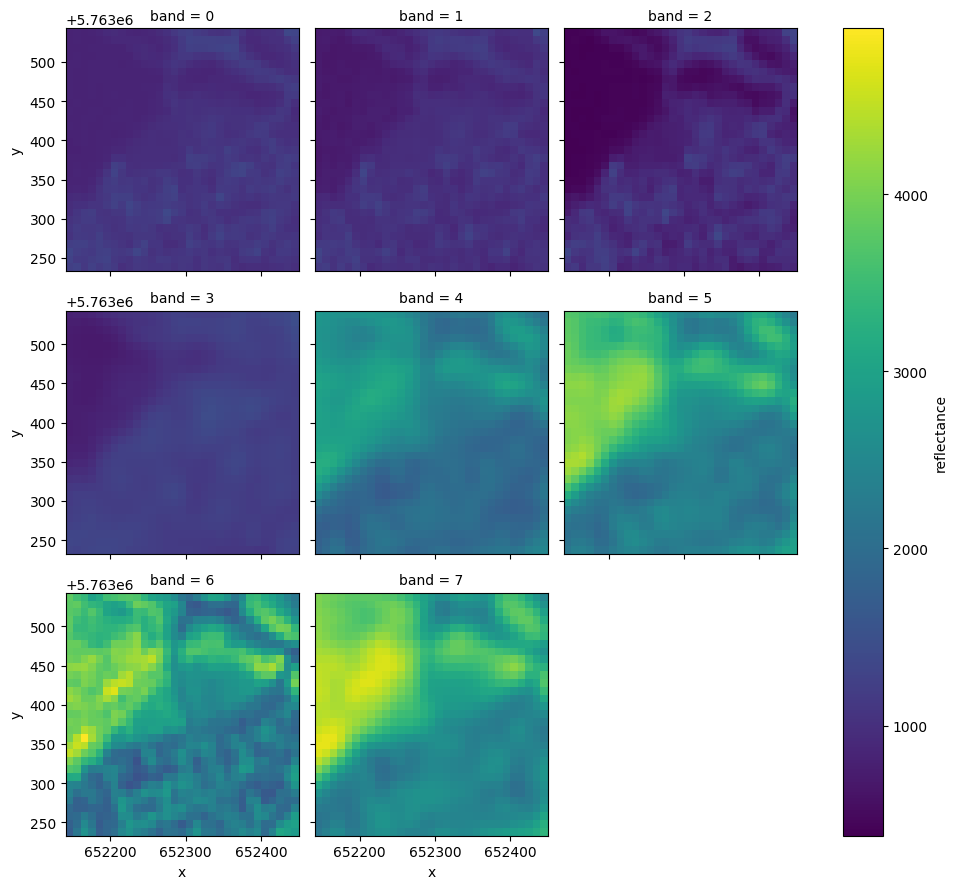

In [16]:
S2A_L1C['reflectance'].isel(band=[0,1,2,3,4,5,6,7]).plot(col='band', col_wrap=3)

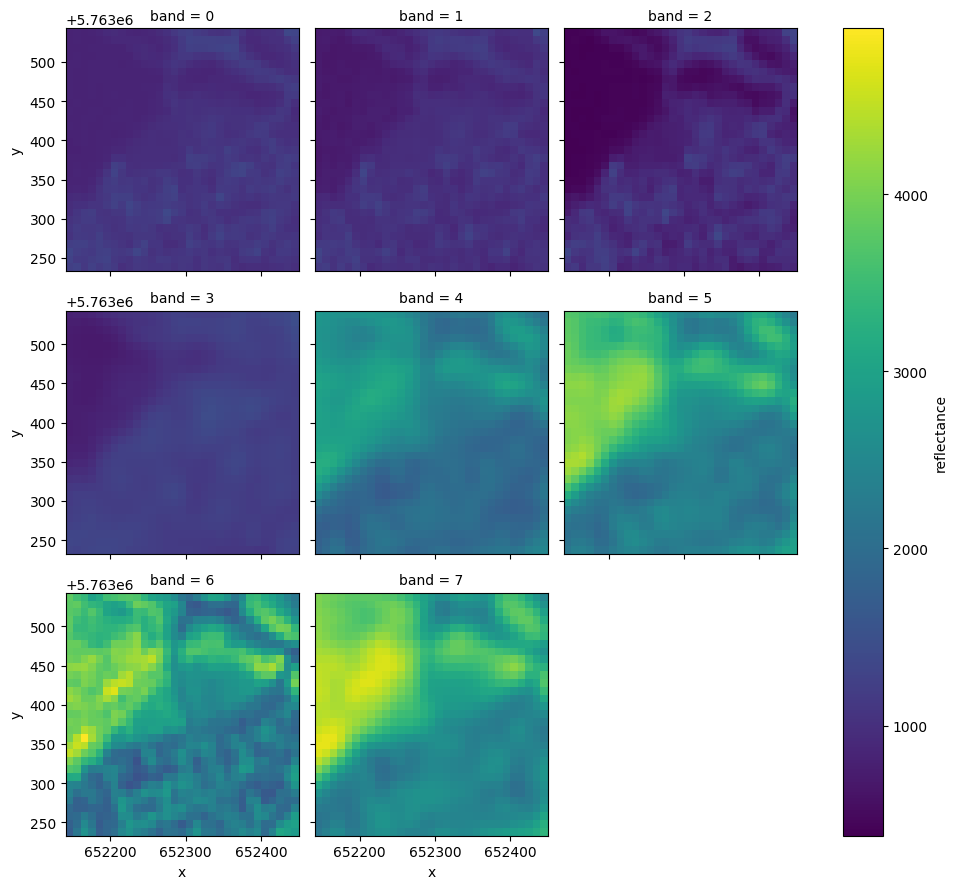

In [17]:
S2A_L2A['reflectance'].isel(band=[0,1,2,3,4,5,6,7]).plot(col='band', col_wrap=3)